In [3]:
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

In [4]:
df = pd.read_csv("data/hole_card_data.csv")

df['suited'] = pd.Categorical(df['suited'], ordered=False)
df['pair'] = pd.Categorical(df['pair'], ordered=False)

In [5]:
embedding_dim = 8
embedder1 = nn.Embedding(169, embedding_dim)
embedder1.load_state_dict(torch.load('hand_embedding_weights/embeddings_model1.pt', 
                                     weights_only=True))

<All keys matched successfully>

In [6]:
with torch.no_grad():
    all_indices = torch.arange(169, dtype=torch.long)
    embeddings1 = embedder1(all_indices).numpy()

In [7]:
for i in range(embedding_dim):
    df[f'embedding{i+1}'] = embeddings1[:,i]

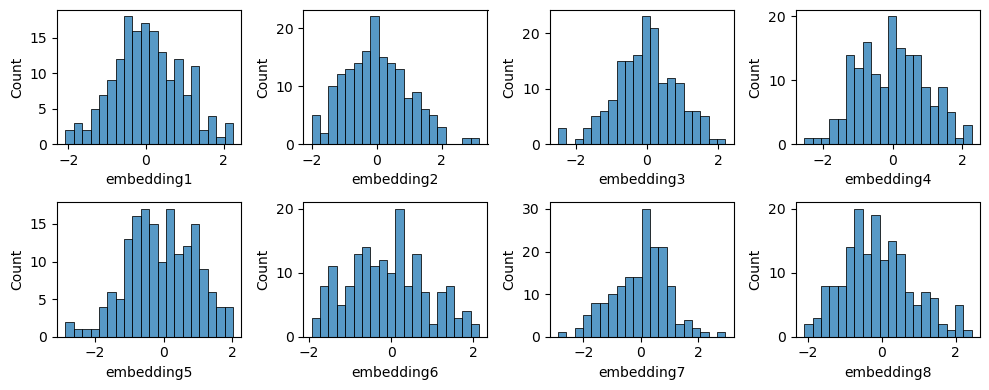

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(10,4))
for i, ax in enumerate(axes.flatten()):
    sns.histplot(df, x=f'embedding{i+1}', ax=ax, bins=20)
plt.tight_layout()
plt.show()

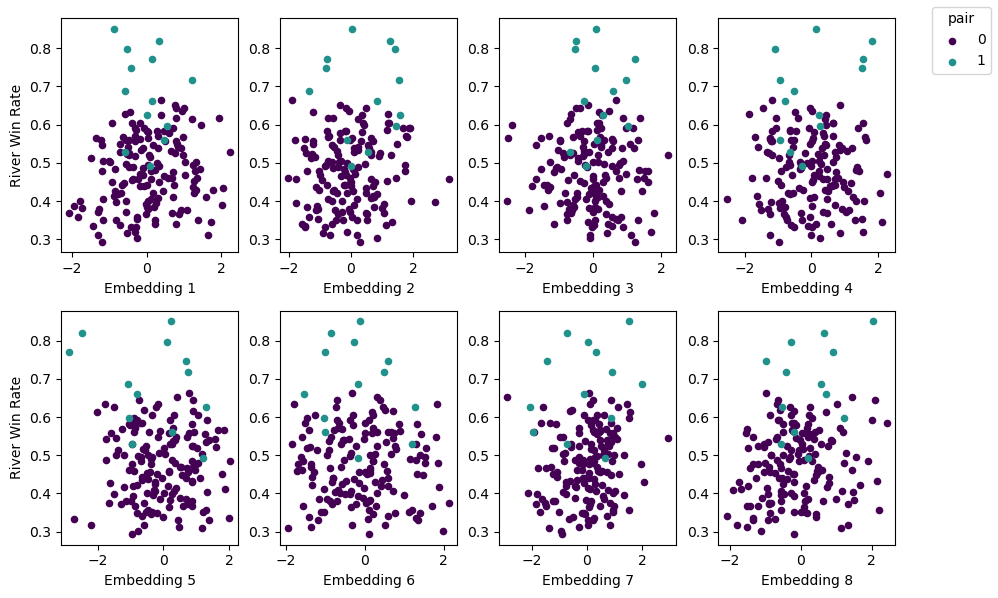

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(10, 6))
colors = ['#440154', '#21918c']
for i, ax in enumerate(axes.flatten()):
    mask_0 = df['pair'] == 0
    ax.scatter(df.loc[mask_0, f'embedding{i+1}'], df.loc[mask_0, 'river_win_rate'], 
              color=colors[0], s=20, label='0' if i == 0 else "")
    
    mask_1 = df['pair'] == 1
    ax.scatter(df.loc[mask_1, f'embedding{i+1}'], df.loc[mask_1, 'river_win_rate'], 
              color=colors[1], s=20, label='1' if i == 0 else "")
    
    ax.set_xlabel(f'Embedding {i+1}')
    ax.set_ylabel('River Win Rate' if i % 4 == 0 else '')

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, title='pair', loc='upper right')

plt.tight_layout()
plt.subplots_adjust(right=0.9)
plt.show()

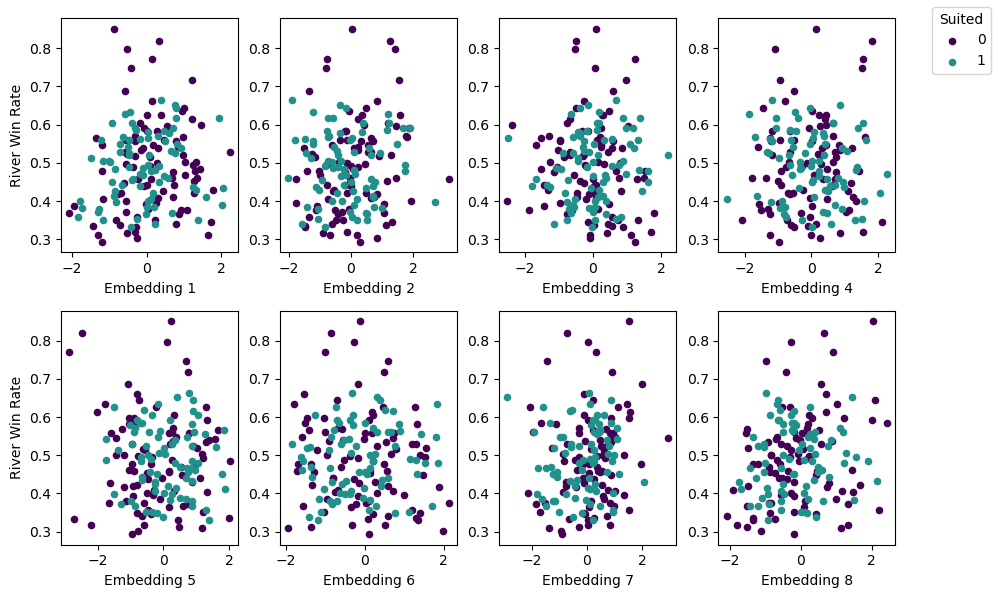

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(10, 6))

colors = ['#440154', '#21918c']

for i, ax in enumerate(axes.flatten()):
    
    mask_0 = df['suited'] == 0
    ax.scatter(df.loc[mask_0, f'embedding{i+1}'], df.loc[mask_0, 'river_win_rate'], 
              color=colors[0], s=20, label='0' if i == 0 else "")
    
    mask_1 = df['suited'] == 1
    ax.scatter(df.loc[mask_1, f'embedding{i+1}'], df.loc[mask_1, 'river_win_rate'], 
              color=colors[1], s=20, label='1' if i == 0 else "")
    
    ax.set_xlabel(f'Embedding {i+1}')
    ax.set_ylabel('River Win Rate' if i % 4 == 0 else '')

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, title='Suited', loc='upper right')

plt.tight_layout()
plt.subplots_adjust(right=0.9)
plt.show()

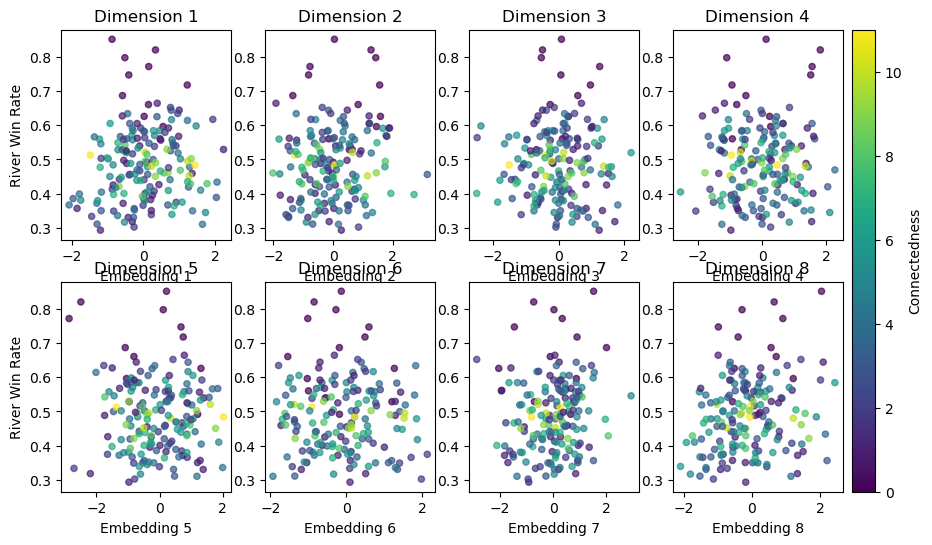

In [11]:
norm = plt.Normalize(df['connectedness'].min(), df['connectedness'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)

fig, axes = plt.subplots(2, 4, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    scatter = ax.scatter(df[f'embedding{i+1}'], df['river_win_rate'], 
                       c=df['connectedness'], cmap='viridis', s=20, alpha=0.7,
                       norm=norm)
    ax.set_xlabel(f'Embedding {i+1}')
    if i % 4 == 0:
        ax.set_ylabel('River Win Rate')
    ax.set_title(f'Dimension {i+1}')
    
cbar = fig.colorbar(sm, ax=axes, pad=0.01)
cbar.set_label('Connectedness')
plt.show()

In [12]:
tsne = TSNE(n_components=2, random_state=29, perplexity=30)
embeddings_2d_tsne = tsne.fit_transform(embeddings1)

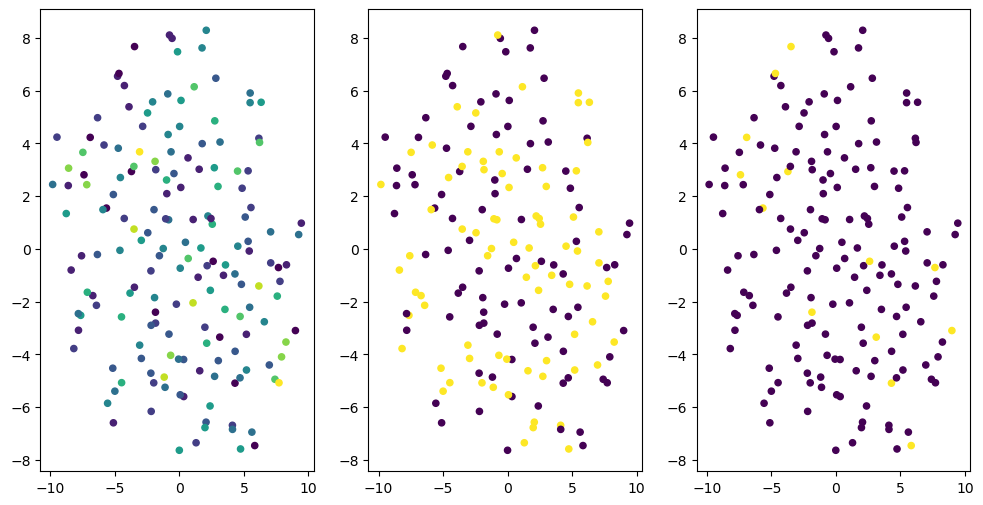

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12,6))
for idx, attribute in enumerate(['connectedness', 'suited', 'pair']):
    axes[idx].scatter(x=embeddings_2d_tsne[:, 0], y=embeddings_2d_tsne[:, 1], 
                    c=df[attribute], s=20)

In [14]:
reducer = umap.UMAP(n_neighbors=15, n_components=2, transform_seed=29)
embeddings_2d_umap = reducer.fit_transform(embeddings1)

c:\Users\campb\miniconda3\envs\ai_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


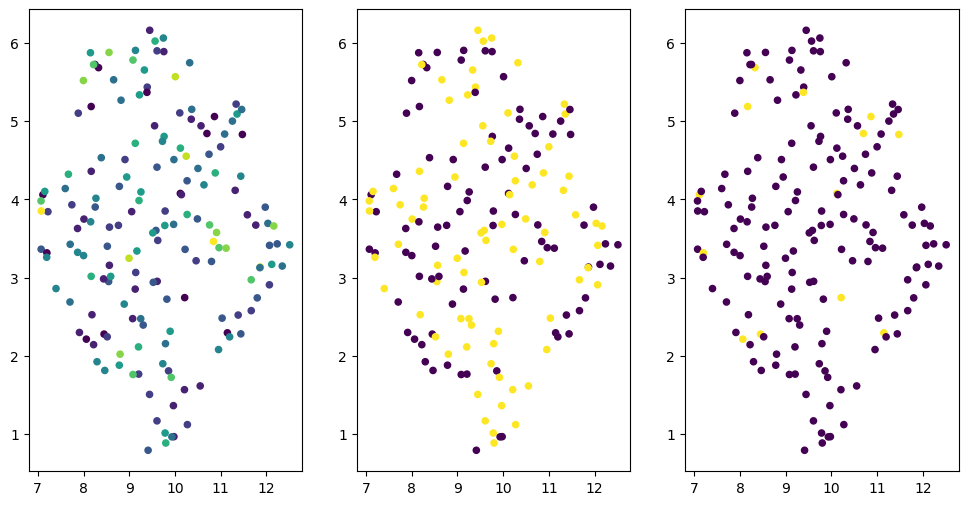

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12,6))
for idx, attribute in enumerate(['connectedness', 'suited', 'pair']):
    axes[idx].scatter(x=embeddings_2d_umap[:, 0], y=embeddings_2d_umap[:, 1], 
                    c=df[attribute], s=20)